In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [2]:
def prune(oper):
    for i in range(oper.shape[0]):
        for j in range(oper.shape[1]):
            x = np.real(oper[i, j])
            y = np.imag(oper[i, j])
            tx = np.round_(x, 15)
            ty = np.round_(y, 15)
            oper[i, j] = tx + 1j*ty
    return oper

In [3]:
I = np.matrix([[1, 0], [0, 1]])

In [4]:
def Rx(theta):
    return np.matrix([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]], dtype=complex)

def Ry(theta):
    return np.matrix([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]], dtype=complex)

def Rz(theta):
    return np.matrix([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]], dtype=complex)

In [5]:
def Bx():
    return prune(np.kron(Rx(-np.pi/2), Rx(-np.pi/2)))

def By():
    return prune(np.kron(Ry(-np.pi/2), Ry(-np.pi/2)))

def Bz():
    return prune(np.kron(Rz(-np.pi/2), Rz(-np.pi/2)))

In [6]:
def createOplist():
    opList = []
    opList.append(np.kron(np.eye(2), np.eye(2)))
    
    opList.append(prune(np.matmul(Bx(), Bx())))
    opList.append(prune(np.matmul(By(), By())))
    opList.append(prune(np.matmul(Bz(), Bz())))
    
    opList.append(prune(np.matmul(Bx(), By())))
    opList.append(prune(np.matmul(By(), Bz())))
    opList.append(prune(np.matmul(Bz(), Bx())))
    opList.append(prune(np.matmul(By(), Bx())))
    
    temp = prune(np.matmul(Bx(), By()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(By(), Bz()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(Bz(), Bx()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(By(), Bx()))
    opList.append(prune(np.matmul(temp, temp)))
    
    return opList

In [7]:
lis = createOplist()

In [8]:
Pi_SR = np.zeros(np.kron(I, I).shape, dtype=complex)
for item in lis:
    Pi_SR += (1/len(lis))*item
Pi_SR = prune(Pi_SR)
print(Pi_SR)

[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


In [9]:
unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326]

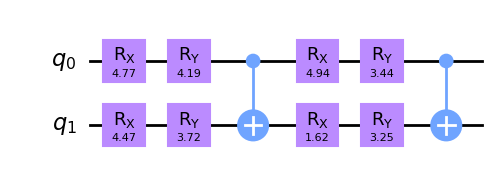

In [10]:
#State \rho_SR
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

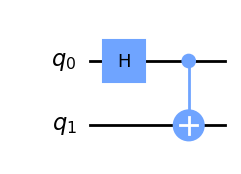

In [48]:
qcTest = QuantumCircuit(2)
qcTest.h(0)
qcTest.cx(0, 1)
qcTest.draw('mpl')

In [49]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = prune(pt(psi, [2], [2, 2])) #rho_S
print(rho)

[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]


In [50]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(Pi_SR.shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [2], [2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

c.append(omega == Pi_SR@omega@Pi_SR)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

Root Fidelity is : 1.0000000337797266


In [51]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 1.0000000675594543
